# Import 

In [8]:
# 의류 데이터 분류하는 모델 만들어보기 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf # 텐서플로우 import 
import numpy as np
import matplotlib.pyplot as plt


# 데이터 불러오기 & 전처리

In [9]:
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data() # 데이터 불러오기. 튜플로 묶어서 반환

In [10]:
# 훈련 세트와 검증 세트로 분류. train_test_split() 사용
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify = y_train_all, test_size = 0.2, random_state = 42) # random_state는 안해도 되는데 예제랑 같다는 걸 보여주기 위해 사용한 것. 20%(test_size = 0.2)를 검증 세트로 나눈다.

In [11]:
# 타깃 데이터를 원-핫 인코딩으로 변환
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

In [13]:
# 입력 데이터 준비
# 이전과는 다르게 입력 데이터를 일렬로 늘릴 필요가 없다. 높이, 너비를 그대로 유지한 채 컬러 채널만 추가해준다.
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)

In [14]:
# 입력 데이터 표준화 처리(경사 하강법을 사용하기 위해 0~1 사이의 값으로 만들기)
x_train = x_train / 255
x_val = x_val / 255

# 모델 클래스

In [21]:
# 합성곱 신경망
class ConvolutionNetwork:
    def __init__(self, n_kernels = 10, units = 10, batch_size = 32, learning_rate = 0.1):

        self.n_kernels = n_kernels
        self.kernel_size = 3
        self.optimizer = None
        # 합성곱 가중치(가중치들의 구성원이 커널), 절편
        self.conv_w = None 
        self.conv_b = None
        self.units = units
        self.batch_size = batch_size
        self.w1 = None 
        self.b1 = None
        self.w2 = None
        self.b2 = None
        self.a1 = None # 은닉층의 활성화 출력
        self.losses = [] # 훈련 손실
        self.val_losses = [] # 검증 손실
        self.lr = learning_rate # 학습률

    def forpass(self,x): # 정방향 계산
        c_out = tf.nn.conv2d(x, self.conv_w, strides=1, padding='SAME') + self.conv_b # 3*3 합성곱 연산 수행(세임 패딩 사용 -> 합성곱 연산을 해도 이미지의 크기는 같음)
        r_out = tf.nn.relu(c_out) # 활성화 함수(렐루) 적용 -> 합성곱 레이어 완성
        p_out = tf.nn.max_pool2d(r_out, ksize=2, strides=2, padding='VALID') # 2*2풀링 연산 적용

        f_out = tf.reshape(p_out, [x.shape[0], -1]) # 첫 번째 배치 차원을 제외하고 합성곱 신경망에서 얻은 출력(특성맵)을 일렬로 펼침. 이 때 배치 차원은 펼치면 안됨. 
        z1 = tf.matmul(f_out, self.w1) + self.b1 # 출력값(선형식) 계산. np.dot() 대신 tf.matmul() 사용. 기능은 같다. 근데 왜 matnul을 쓰냐면 conv2d, max_pool2d이 넘파이 배열이 아니라 tensor 객체를 반환하기 때문. 
        a1 = tf.nn.relu(z1) # 활성화 함수 적용. 시그모이드 대신 렐루 사용.
        z2 = tf.matmul(a1, self.w2) + self.b2 # 두번 째 층의 선형식 계산
        return z2

    def init_weights(self, input_shape, n_classes):
        # 가중치를 glorot_uniform()로 초기화한다. glorot_uniform()는 글로럿(glorot) 초기화 방법을 이용해 초기화한다. 글로럿 초기화 방법은 -sqrt(6/(입력 뉴런 수 + 출력 뉴런 수))와 sqrt(6/(입력 뉴런 수 + 출력 뉴런 수)) 사이에 있는 임의의 값으로 가중치를  초기화한다. 이렇게 하는 이유는 local minimum 찾고 '이게 최적값이다!'하는 에러를 피하기 위함이다. 우리의 목적은 global minimum을 찾는 것이다. 
        # 참고로 glorot_uniform()은 GlolorUniform 클래스의 별명이다. 클래스 객체를 함수처럼 호출하면 __call__()이 호출되어  난수가 생성된 후 반환된다. 
        g = tf.initializers.glorot_uniform()
        # 넘파이 함수 대신 tf.Variable()를 사용하는 이유는 사용할 함수들이 모두 tensor 객체를 입력값으로 받기 때문이다. 객체 변환의 귀찮음을 피하기 위해 tf.Variable()를 쓴다고 보면 된다. 
        # tf.Variable()는 입력값에 따라 자료형이 자동으로 결정된다. 

        # 가중치를 초기화할 때 glorot_uniform()에 입력값을 넣어서 초기화 한다. conv_w같은 경우 3*3*1*n_kernels의 크기로 4차원 배열 가중치를 초기화 한다. 왜 1이냐면 흑백 이미지기 때문에 채녈이 하나밖에 없기 때문. 
        self.conv_w = tf.Variable(g((3, 3, 1, self.n_kernels)))
        self.conv_b = tf.Variable(np.zeros(self.n_kernels), dtype = float)
        n_features = 14 * 14 * self.n_kernels # 특성맵의 갯수. 참고로 n_kernels은 만들어진 특성의 갯수다.(내가 합성곱 레이어에 넣은 커널 개수 = 출력값으로 나오는 특성 개수. 당연한거다.)

        self.w1 = tf.Variable(g((n_features, self.units))) # (특성 개수, 은닉층 크기) <- 완전 연결층으로 이루어진 신경망에 값을 넣기 전에 이미지를 일렬로 쫙 늘린다. 그렇기 때문에 배열의 크기는 14*14*n_kernels가 된다.
        self.b1 = tf.Variable(np.zeros(self.units), dtype = float) # 은닉층의 크기
        self.w2 = tf.Variable(g((self.units, n_classes))) # (은닉층의 크기, 클래스 개수)
        self.b2 = tf.Variable(np.zeros(n_classes), dtype = float) # 클래스 개수

    def fit(self, x, y, epochs = 100, x_val = None, y_val = None):
        # 초기화 파트
        self.init_weights(x.shape, y.shape[1]) # 은닉층과 출력층의 가중치를 초기화
        self.optimizer = tf.optimizers.SGD(learning_rate=self.lr) # 옵티마이저 객체 생성. 텐서플로우는 다양한 경사 하강법(=학습 방법)을 구현해놨다. SGD(확률적 경사 하강법)는 기본 경사 하강법이다. 

        # 에포크만큼 반복(훈련 파트)
        for i in range(epochs):
            print('에포크', i, end=' ')
            # 미니 배치 순환
            batch_losses = [] 
            for x_batch, y_batch in self.gen_batch(x, y):
                print('.', end=' ')
                self.training(x_batch, y_batch)
                batch_losses.append(self.get_loss(x_batch, y_batch))
            print()
            # 배치 손실 평균을 내어 훈련 손실값으로 저장
            self.losses.append(np.mean(batch_losses))
            # 검증 세트에 대한 손실 기록
            self.val_losses.append(self.get_loss(x_val, y_val))
        
    def gen_batch(self, x, y): 
        bins = len(x) // self.batch_size # 미니 배치가 몇개 있는가? (//연산자는 '몫'을 의미)
        indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞음. x길이만큼 생성된 [0, 1, 2, ...] 배열을 셔플한 걸 반환
        #이 코드를 왜 쓰는거지? ======
        x = x[indexes]
        y = y[indexes]
        #이 코드를 왜 쓰는거지? ======
        for i in range(bins):
            start = self.batch_size*i
            end = self.batch_size*(i+1)
            yield x[start:end], y[start:end] # 배치 사이즈만큼 잘라서 반환

    def training(self, x, y):
        m = len(x)

        # 합성곱의 역방향 계산을 직접 구현하는 것은 복잡하기도 하면서 학습에 별로 도움이 안된다.
        # 그래서 그레디언트를 구하기 위해 텐서플로우의 자동 미분(automatic differentiation)을 사용한다. 
        # 자동 미분 : 사용자가 작성한 연산을 계산 그래프(computation graph)로 만들어 자동 미분 기능을 구현. 자동 미분 기능을 사용하면 임의의 파이썬 코드나 함수에 대한 미분값을 계산할 수 있음.
        with tf.GradientTape() as tape: # 자동 미분 기능을 사용하기 위해 with블럭으로 tf.GradientTape() 객체가 감시할 코드를 감싼다. with~as : 파일을 다룰 때 유용하다고 한다. open, close를 자동으로 해준다고. 자바의 try~catch로 파일 입출력 프로그램을 편하게 구현하는 것이 연상된다.
            # 아무튼, 미분 대상 객체와 변수를 tf.GradientTape()에 전달하면 출력값으로 그레디언트들을 얻을 수 있다.
            # 원래 backprop()로 역방향 계산을 하며 그레디언트를 구하고(역방향 계산의 목적이 그레디언트 구해서 가중치, 절편 업데이트 위함이니) 가중치를 업데이트 하는건데 자동 미분을 사용하면 굳이 역방향 함수를 사용할 이유가 없다. 
            # 왜냐하면 자동 미분으로 그레디언트를 구할 수 있으니까. 
            z = self.forpass(x) # 정방향 계산. z=f(x)
            loss = tf.nn.softmax_cross_entropy_with_logits(y, z) # softmax_cross_entropy_with_logits()을 이용해 결과(z)와 타깃(y)을 기반으로 손실값 계산. 이 함수 호출 한 번으로 크로스 앤트로피 손실과 그레디언트 계산을 올바르게 처리할 수 있다. 편리하다.
            loss = tf.reduce_mean(loss) # softmax_cross_entropy_with_logits()는 각 샘플에 대한 손실을 반환하니 모아서 평균을 구한다. 
        
        # 위 with~as 블럭 안에 들어있는 애들은 그레디언트 계산을 하기 위해 사전 준비를 하는 것이라 생각하면 된다. 역방향 연산의 한 과정을 위와 같이 표현한거라 봐도 될듯 하다.
        weights_list = [self.conv_w, self.conv_b, self.w1, self.b1, self.w2, self.b2] # 업데이트할 애들
        # 가중치에 대한 그레디언트 계산
        grads = tape.gradient(loss, weights_list)
        # apply_gradients()로 가중치 업데이트. apply_gradients()는 입력값으로 튜플을 받기 때문에 그레디언트와 업데이트할 것들을 튜플로 묶는다. 
        self.optimizer.apply_gradients(zip(grads, weights_list)) # optimizer 객체 덕분에 경사 하강법 알고리즘을 바꾸어가며 테스트하기 편하다. 앞서 fit()에서 optimizer를 초기화 했었다. 이 클래스에선 확률적 경사 하강법으로 그레디언트를 가지고 가중치와 절편을 업데이트를 하는 것이다. 

    def predict(self, x):
        z = self.forpass(x)
        return np.argmax(z.numpy(), axis = 1) # 가장 큰 값의 인덱스 반환
    
    def score(self, x, y):
        # True비율 반환
        return np.mean(self.predict(x) == np.argmax(y, axis = 1))
    
    def get_loss(self, x, y):
        z = self.forpass(x)
        # 손실을 계산해 저장
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, z))
        return loss.numpy()

# 훈련하기

In [22]:
cn = ConvolutionNetwork(n_kernels=10, units=100, batch_size=128, learning_rate=0.01)
cn.fit(x_train, y_train_encoded, x_val = x_val, y_val = y_val_encoded, epochs = 20)

에포크 0 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
에포크 1 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

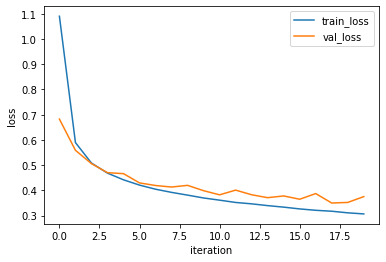

In [23]:
plt.plot(cn.losses)
plt.plot(cn.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

# 훈련 모델 점수 비교. 조금씩 차이가 나긴 하지만 그래도 훈련이 잘 되고 있음.

In [24]:
cn.score(x_val, y_val_encoded) # 점수 확인. 약 88%의 정확도

0.86625

### 실전에서는 위와 같이 직접 제작한 저수준 연산을 사용하는 것보다 케라스와 같은 고수준 API를 사용하는 것이 편리하고 생산적.